In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_FOLDER = 'data/'

/opt/miniconda3/envs/ml_project_2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_input, train_target = torch.load(DATA_FOLDER + 'train_data.pkl')
val_input, val_target = torch.load(DATA_FOLDER + 'val_data.pkl')

In [32]:
df = pd.read_csv(DATA_FOLDER + 'BTC-USD.csv')
df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df['log_return'] = np.log(df['Adj Close']/df['Adj Close'].shift(-1))
df.drop(columns='Adj Close', inplace=True)
df.dropna(inplace=True)

In [44]:
df

,Date,Adj Close,log_return
0,2014-09-17,457.334015,0.074643
1,2014-09-18,424.440002,0.072402
2,2014-09-19,394.795990,-0.035111
3,2014-09-20,408.903992,0.024968
4,2014-09-21,398.821014,-0.008317
...,...,...,...
1572,2019-01-06,4076.632568,0.012685
1573,2019-01-07,4025.248291,-0.001390
1574,2019-01-08,4030.847900,-0.001103
1575,2019-01-09,4035.296387,0.092459


In [33]:
plt.plot(torch.cat((train_target, val_target))[-100:])
plt.plot(df['log_return'].shift(0).iloc[-100:].reset_index(drop=True))
plt.show()

NameError: name 'train_target' is not defined

In [34]:
df = pd.read_csv(DATA_FOLDER + 'BTC-USD.csv')
df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df['log_return'] = np.log(df['Adj Close']/df['Adj Close'].shift(-1))
# df.drop(columns='Adj Close', inplace=True)
# df.dropna(inplace=True)

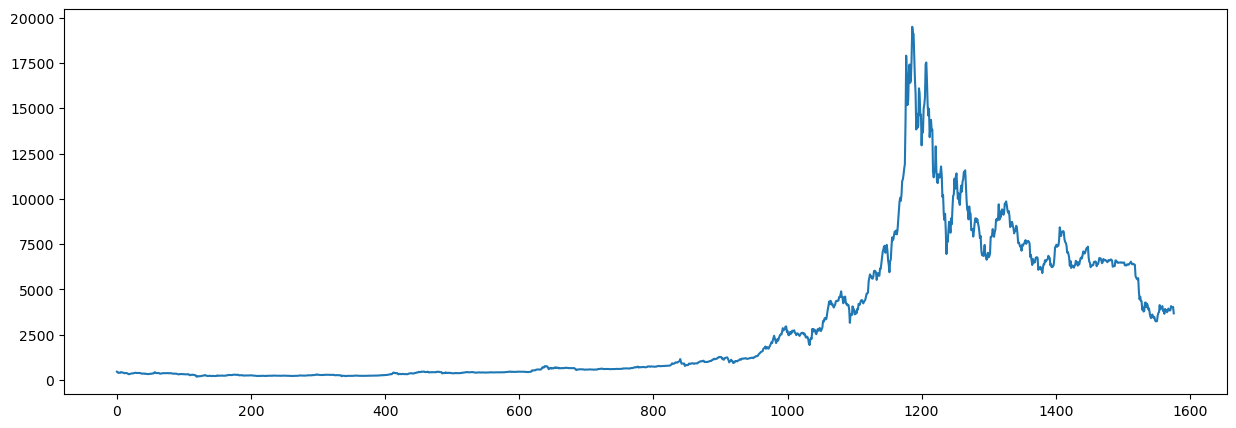

In [36]:
fig = plt.figure(figsize=(15,5))
plt.plot(df['Adj Close'])

In [122]:
import torch
import quandl
import pandas as pd
import numpy as np

DATA_FOLDER = '../data/'


def load_data(path):
    # df = pd.read_csv(path)
    # df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
    # df['Date'] = pd.to_datetime(df['Date'])

    # df['log_return'] = np.log(df['Adj Close']/df['Adj Close'].shift(-1))
    # df.drop(columns='Adj Close', inplace=True)
    #df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # df.dropna(inplace=True)
    
    df = quandl.get("BCHARTS/BITSTAMPUSD", start_date="2014-04-15", end_date="2019-01-10")
    df['log_return'] = np.log(df['Weighted Price']/df['Weighted Price'].shift(-1))
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df


def split_data(df, train_ratio):
    # date = df['Date'].iloc[int(train_ratio*len(df))]
    # train_period = (df['Date'] < date)
    # val_period = (df['Date'] >= date)

    # df_train = df.loc[train_period]
    # df_val = df.loc[val_period]
    
    train_ratio = 0.5
    date = df.index[int(train_ratio*len(df))]
    train_period = (df.index < date)
    val_period = (df.index >= date)

    df_train = df.loc[train_period]
    df_val = df.loc[val_period]
    return df_train, df_val


def create_sequences(df, nb_lags):
    sequences = torch.empty((len(df)-nb_lags, nb_lags))
    targets = torch.empty(len(df)-nb_lags)
    
    for i in range(len(df)-nb_lags):
        sequences[i,:] = torch.tensor(df['log_return'].iloc[i:i+nb_lags].values)
        targets[i] = torch.tensor(df['log_return'].iloc[i+nb_lags])
    
    return sequences, targets

In [123]:
df = load_data(DATA_FOLDER + 'BTC-USD.csv')
df_train, df_val = split_data(df, train_ratio=0.5)
train_input, train_target = create_sequences(df_train, nb_lags=6)
val_input, val_target = create_sequences(df_val, nb_lags=6)

/opt/miniconda3/envs/ml_project_2/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [125]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm
#from pathlib import Path


class Model(nn.Module):
    def __init__(self, nb_lags, lr):
        # instantiate model + optimizer + loss function 
        super(Model, self).__init__()
        self.layer1 = nn.Linear(in_features=nb_lags, out_features=6)
        self.layer2 = nn.Linear(in_features=6, out_features=3)
        self.layer3 = nn.Linear(in_features=3, out_features=1)
        
        self.optimizer = optim.Rprop(self.parameters(), lr=lr)
        #self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')
        self.criterion = nn.MSELoss(reduction='sum')

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)  
    
    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        x = self.layer3(x)
        return x.view(-1)
    
    def train(self, train_input, train_target, num_epochs, mini_batch_size):
            # train_input : tensor of size (N, D) where D is the numbers of lags used to forecast
            # train_target : tensor of size (N)

            train_losses = []
            lr_history = []
            for e in tqdm(range(num_epochs), desc='Training model', unit=' epoch'):
                epoch_loss = 0
                #shuffled_idx = torch.randperm(train_input.size(0))
                #train_input = train_input[shuffled_idx,:]
                #train_target = train_target[shuffled_idx]
                
                #for b in range(0, mini_batch_size*int(train_input.size(0)/mini_batch_size), mini_batch_size):
                    #output = self(train_input.narrow(0, b, mini_batch_size))
                    #loss = self.criterion(output, train_target.narrow(0, b, mini_batch_size))
                    #epoch_loss += loss.item()
                    #self.optimizer.zero_grad()
                    #loss.backward()
                    #self.optimizer.step()
                
                output = self(train_input)
                loss = self.criterion(output, train_target)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                #self.scheduler.step(epoch_loss)
                #print("Epoch {}: Loss {}".format(e, epoch_loss))
                train_losses.append(loss.item())
                #lr_history.append(self.get_lr())
            
            self.train_losses = train_losses
            #self.lr_history = lr_history

    def test(self, val_input, val_target):
        output = self(val_input)
        positive_forecast = output > 0

        #rate = output.sign().eq(val_target.sign()).sum() / val_target.size(0)
        self.hit_rate = output[positive_forecast].sign().eq(val_target[positive_forecast].sign()).sum() / positive_forecast.sum()


    #def get_lr(self):
        #for param_group in self.optimizer.param_groups:
            #return param_group['lr']
      
    # def predict(self, test_input):
    #     test_output = self(test_input)
    #     return test_output

Training model: 100%|██████████| 1000/1000 [00:00<00:00, 2676.22 epoch/s]


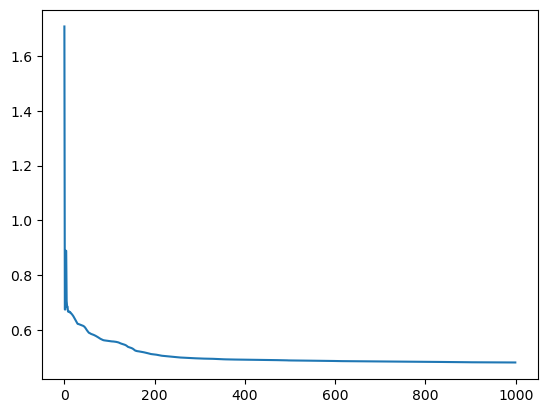

In [126]:
model = Model(nb_lags=6, lr=1e-2)

# ######################### Load training data: #########################
# train_input, train_target = torch.load(DATA_FOLDER + 'train_data.pkl')
# train_input, train_target = train_input.to(model.device), train_target.to(model.device)

# ######################### Load validation data: #########################
# val_input, val_target = torch.load(DATA_FOLDER + 'val_data.pkl')
# val_input, val_target = val_input.to(model.device), val_target.to(model.device)

# Standardize:
mean = train_target.mean().item()
std = train_target.std().item()
min_ = train_target.min()
max_ = train_target.max()

# train_input = (train_input-mean)/std
# train_target = (train_target-mean)/std
# val_input = (val_input-mean)/std
# val_target = (val_target-mean)/std

######################### Training: #########################
train = True
if train:
    losses = model.train(train_input, train_target, num_epochs=1000, mini_batch_size=100)
    torch.save(model, 'models/bestmodel.pth')

######################### Validation: #########################
model = torch.load('models/bestmodel.pth')
model.test(val_input, val_target)

######################### Plot training loss: #########################
plt.plot(model.train_losses)
plt.show()